Non-numeric columns: Index(['Time_1900-01-01 17:14:53', 'Time_1900-01-01 17:14:54',
       'Time_1900-01-01 17:14:55', 'Time_1900-01-01 17:14:56',
       'Time_1900-01-01 17:14:57', 'Time_1900-01-01 17:14:58',
       'Time_1900-01-01 17:14:59', 'Time_1900-01-01 17:15:00',
       'Time_1900-01-01 17:15:01', 'Time_1900-01-01 17:15:02',
       ...
       'Time_1900-01-01 18:56:09', 'Time_1900-01-01 18:56:10',
       'Time_1900-01-01 18:56:11', 'Time_1900-01-01 18:56:12',
       'Time_1900-01-01 18:56:13', 'Time_1900-01-01 18:56:14',
       'Time_1900-01-01 18:56:15', 'Time_1900-01-01 18:56:16',
       'Time_1900-01-01 18:56:17', 'Time_1900-01-01 18:56:18'],
      dtype='object', length=1430)


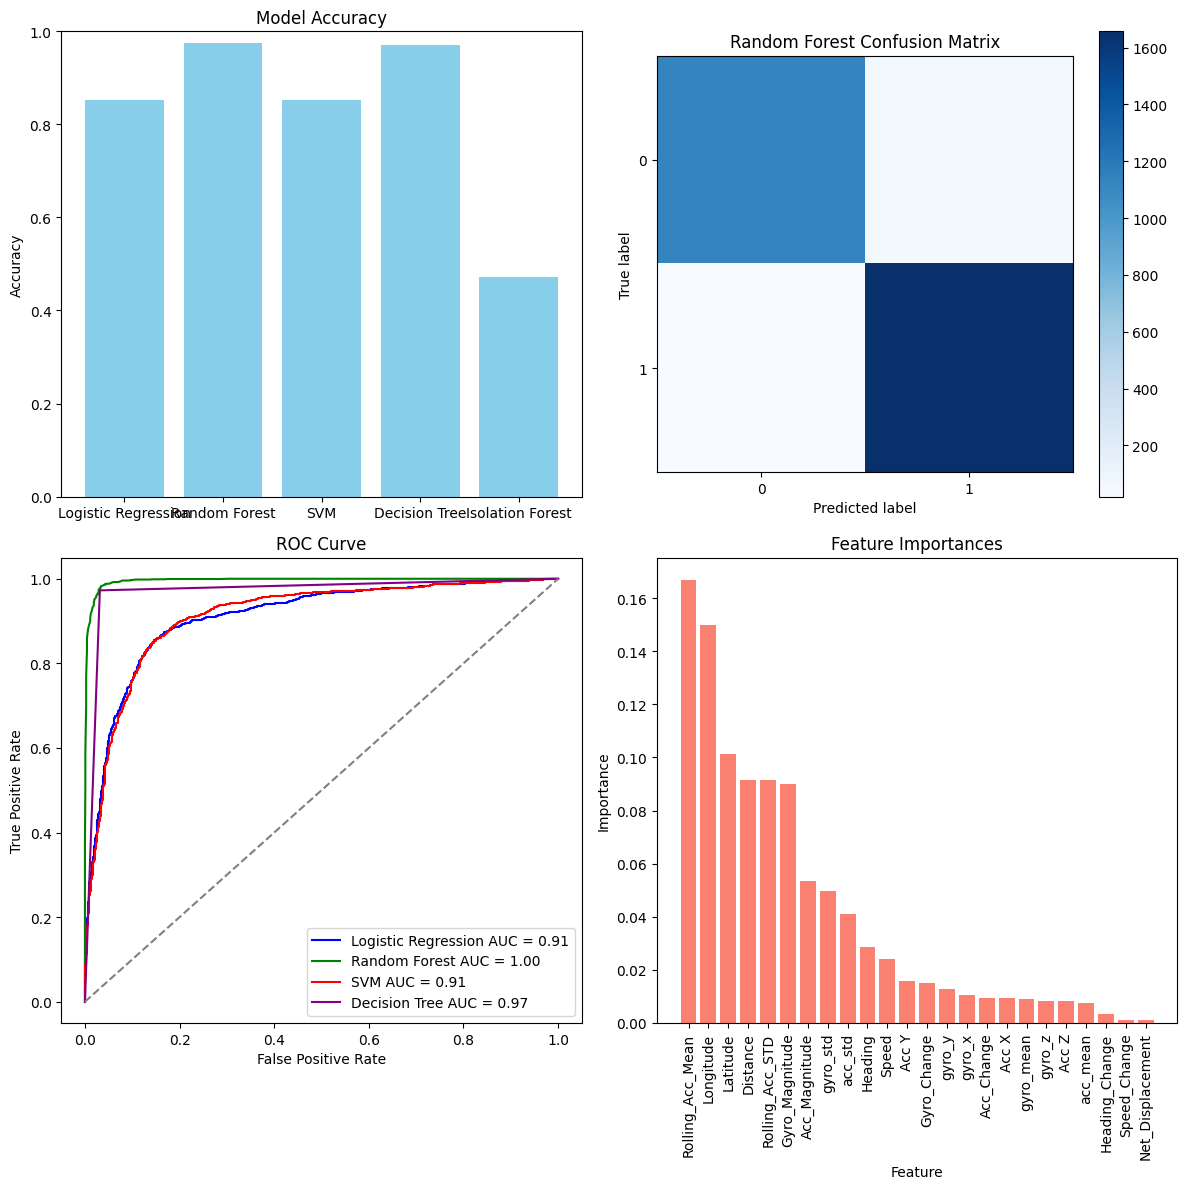

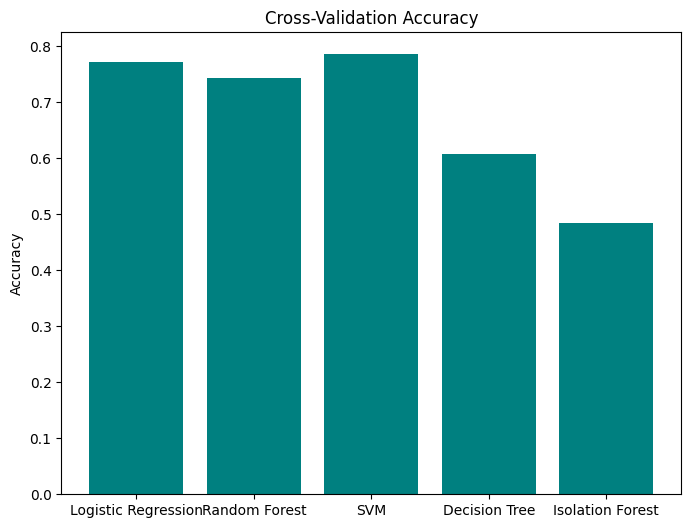

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV

# Step 1: Load the dataset
data = pd.read_csv('Featured_dataset.csv')

# Step 2: Define features and target variable
X = data.drop(columns=['label'])  # Features
y = data['label']  # Target variable

# Step 3: Handle Non-Numeric Columns
# Convert non-numeric columns to category codes or drop them
X = pd.get_dummies(X)  # Converts categorical columns to dummy variables (if any)

# Identify columns with non-numeric data that should be excluded or processed (like datetime)
non_numeric_columns = X.select_dtypes(exclude=[np.number]).columns
print("Non-numeric columns:", non_numeric_columns)

# Drop non-numeric columns (if not needed)
X = X.select_dtypes(include=[np.number])

# Step 4: Handle Missing Data
X.fillna(X.mean(), inplace=True)  # Fill missing values in numeric columns with the column mean

# Step 5: Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 7: Model Selection
# Baseline Model - Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)

# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)

# Support Vector Machine (SVM)
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

# Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)

# Isolation Forest for anomaly detection
iso_forest = IsolationForest(random_state=42)
iso_forest.fit(X_train)
y_pred_iso = iso_forest.predict(X_test)
y_pred_iso = np.where(y_pred_iso == 1, 0, 1)  # Convert to binary labels (1 for anomaly)

# Step 8: Model Evaluation and Visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# 1. Accuracy Plot
axes[0, 0].bar(['Logistic Regression', 'Random Forest', 'SVM', 'Decision Tree', 'Isolation Forest'], 
               [accuracy_log_reg, accuracy_rf, accuracy_svm, accuracy_dt, accuracy_score(y_test, y_pred_iso)], color='skyblue')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_ylim(0, 1)

# 2. Confusion Matrix for Random Forest
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
axes[0, 1].imshow(conf_matrix_rf, interpolation='nearest', cmap=plt.cm.Blues)
axes[0, 1].set_title('Random Forest Confusion Matrix')
axes[0, 1].set_xlabel('Predicted label')
axes[0, 1].set_ylabel('True label')
plt.colorbar(mappable=axes[0, 1].imshow(conf_matrix_rf, interpolation='nearest', cmap=plt.cm.Blues), ax=axes[0, 1])
axes[0, 1].set_xticks([0, 1])
axes[0, 1].set_yticks([0, 1])

# 3. ROC Curve for all models
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, log_reg.predict_proba(X_test)[:, 1])
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm.decision_function(X_test))
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt.predict_proba(X_test)[:, 1])

axes[1, 0].plot(fpr_log_reg, tpr_log_reg, color='blue', label='Logistic Regression AUC = %0.2f' % auc(fpr_log_reg, tpr_log_reg))
axes[1, 0].plot(fpr_rf, tpr_rf, color='green', label='Random Forest AUC = %0.2f' % auc(fpr_rf, tpr_rf))
axes[1, 0].plot(fpr_svm, tpr_svm, color='red', label='SVM AUC = %0.2f' % auc(fpr_svm, tpr_svm))
axes[1, 0].plot(fpr_dt, tpr_dt, color='purple', label='Decision Tree AUC = %0.2f' % auc(fpr_dt, tpr_dt))
axes[1, 0].plot([0, 1], [0, 1], color='gray', linestyle='--')
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('ROC Curve')
axes[1, 0].legend(loc='lower right')

# 4. Feature Importances (Random Forest)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

axes[1, 1].bar(range(len(importances)), importances[indices], align='center', color='salmon')
axes[1, 1].set_title('Feature Importances')
axes[1, 1].set_xticks(range(len(importances)))
axes[1, 1].set_xticklabels(X.columns[indices], rotation=90)
axes[1, 1].set_xlabel('Feature')
axes[1, 1].set_ylabel('Importance')

plt.tight_layout()
plt.show()

# Step 9: Cross-Validation (Visualized)
fig, ax = plt.subplots(figsize=(8, 6))
models = [log_reg, rf, svm, dt, iso_forest]
model_names = ['Logistic Regression', 'Random Forest', 'SVM', 'Decision Tree', 'Isolation Forest']
cv_accuracies = []

for model in models:
    if model == iso_forest:
        # Isolation Forest does not support cross_val_score directly; using a custom method
        scores = cross_val_score(iso_forest, X_scaled, y, cv=5, scoring='accuracy')
    else:
        scores = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy')
    cv_accuracies.append(scores.mean())

ax.bar(model_names, cv_accuracies, color='teal')
ax.set_title('Cross-Validation Accuracy')
ax.set_ylabel('Accuracy')
plt.show()
